In [7]:
import argparse
import time
from pathlib import Path
import sys

import cv2
import torch
import torch.backends.cudnn as cudnn
from numpy import random

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel

In [76]:
def detect( args,save_img=False):
    source, weights, view_img, save_txt, imgsz, trace = args.source, args.weights, args.view_img, args.save_txt, args.img_size, not args.no_trace
    save_img = not args.nosave and not source.endswith('.txt')  # save inference images
    webcam = source.isnumeric() or source.endswith('.txt') or source.lower().startswith(
        ('rtsp://', 'rtmp://', 'http://', 'https://'))

    # Directories
    save_dir = Path(increment_path(Path(args.project) / args.name, exist_ok=args.exist_ok))  # increment run
    (save_dir / 'labels' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

    # Initialize
    set_logging()
    device = select_device(args.device)
    half = device.type != 'cpu'  # half precision only supported on CUDA

    # Load model
    model = attempt_load(weights, map_location=device)  # load FP32 model
    stride = int(model.stride.max())  # model stride
    imgsz = check_img_size(imgsz, s=stride)  # check img_size

    if trace:
        model = TracedModel(model, device, args.img_size)

    if half:
        model.half()  # to FP16

    # Second-stage classifier
    classify = False
    if classify:
        modelc = load_classifier(name='resnet101', n=2)  # initialize
        modelc.load_state_dict(torch.load('weights/resnet101.pt', map_location=device)['model']).to(device).eval()

    # Set Dataloader
    vid_path, vid_writer = None, None
    if webcam:
        view_img = check_imshow()
        cudnn.benchmark = True  # set True to speed up constant image size inference
        dataset = LoadStreams(source, img_size=imgsz, stride=stride)
    else:
        dataset = LoadImages(source, img_size=imgsz, stride=stride)

    # Get names and colors
    names = model.module.names if hasattr(model, 'module') else model.names
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]

    # Run inference
    if device.type != 'cpu':
        model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once
    old_img_w = old_img_h = imgsz
    old_img_b = 1

    t0 = time.time()
    for path, img, im0s, vid_cap in dataset:
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Warmup
        if device.type != 'cpu' and (old_img_b != img.shape[0] or old_img_h != img.shape[2] or old_img_w != img.shape[3]):
            old_img_b = img.shape[0]
            old_img_h = img.shape[2]
            old_img_w = img.shape[3]
            for i in range(3):
                model(img, augment=args.augment)[0]

        # Inference
        t1 = time_synchronized()
        with torch.no_grad():   # Calculating gradients would cause a GPU memory leak
            pred = model(img, augment=args.augment)[0]
        t2 = time_synchronized()

        # Apply NMS
        pred = non_max_suppression(pred, args.conf_thres, args.iou_thres, classes=args.classes, agnostic=args.agnostic_nms)
        t3 = time_synchronized()

        # Apply Classifier
        if classify:
            pred = apply_classifier(pred, modelc, img, im0s)

        # Process detections
        for i, det in enumerate(pred):  # detections per image
            if webcam:  # batch_size >= 1
                p, s, im0, frame = path[i], '%g: ' % i, im0s[i].copy(), dataset.count
            else:
                p, s, im0, frame = path, '', im0s, getattr(dataset, 'frame', 0)

            p = Path(p)  # to Path
            save_path = str(save_dir / p.name)  # img.jpg
            txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # img.txt
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
            if len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

                # Write results
                for *xyxy, conf, cls in reversed(det):
                    if save_txt:  # Write to file
                        xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                        line = (cls, *xywh, conf) if args.save_conf else (cls, *xywh)  # label format
                        with open(txt_path + '.txt', 'a') as f:
                            f.write(('%g ' * len(line)).rstrip() % line + '\n')

                    if save_img or view_img:  # Add bbox to image
                        label = f'{names[int(cls)]} {conf:.2f}'
                        plot_one_box(xyxy, im0, label=label, color=colors[int(cls)], line_thickness=2)
                        x1 = int(xyxy[0].item())
                        y1 = int(xyxy[1].item())
                        x2 = int(xyxy[2].item())
                        y2 = int(xyxy[3].item())
                        bbox_points=[x1, y1, x2, y2]
                        print('Bounding box : ',bbox_points)

            # Print time (inference + NMS)
            print(f'{s}Done. ({(1E3 * (t2 - t1)):.1f}ms) Inference, ({(1E3 * (t3 - t2)):.1f}ms) NMS')

            # Stream results
            if view_img:
                cv2.imshow(str(p), im0)
                cv2.waitKey(1)  # 1 millisecond

            # Save results (image with detections)
            if save_img:
                if dataset.mode == 'image':
                    cv2.imwrite(save_path, im0)
                    print(f" The image with the result is saved in: {save_path}")
                else:  # 'video' or 'stream'
                    if vid_path != save_path:  # new video
                        vid_path = save_path
                        if isinstance(vid_writer, cv2.VideoWriter):
                            vid_writer.release()  # release previous video writer
                        if vid_cap:  # video
                            fps = vid_cap.get(cv2.CAP_PROP_FPS)
                            w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                            h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                        else:  # stream
                            fps, w, h = 30, im0.shape[1], im0.shape[0]
                            save_path += '.mp4'
                        vid_writer = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
                    vid_writer.write(im0)

    if save_txt or save_img:
        s = f"\n{len(list(save_dir.glob('labels/*.txt')))} labels saved to {save_dir / 'labels'}" if save_txt else ''
        #print(f"Results saved to {save_dir}{s}")

    print(f'Done. ({time.time() - t0:.3f}s)')


In [101]:
def cmdargs(parser):
    parser.add_argument('--weights', nargs='+', type=str, default='coneslayer.pt', help='model.pt path(s)') #default='yolov7.pt'
    parser.add_argument('--source', type=str, default='cone_predict.jpg', help='source')  # file/folder, 0 for webcam #default='inference/images'
    parser.add_argument('--img-size', type=int, default=640, help='inference size (pixels)') #default=640
    parser.add_argument('--conf-thres', type=float, default=0.54, help='object confidence threshold')#default=0.25
    parser.add_argument('--iou-thres', type=float, default=0.50, help='IOU threshold for NMS') #default=0.45
    parser.add_argument('--device', default='', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
    parser.add_argument('--view-img', action='store_true', help='display results')
    parser.add_argument('--save-txt', action='store_true', help='save results to *.txt')
    parser.add_argument('--save-conf', action='store_true', help='save confidences in --save-txt labels')
    parser.add_argument('--nosave', action='store_true', help='do not save images/videos')
    parser.add_argument('--classes', nargs='+', type=int, help='filter by class: --class 0, or --class 0 2 3')
    parser.add_argument('--agnostic-nms', action='store_true', help='class-agnostic NMS')
    parser.add_argument('--augment', action='store_true', help='augmented inference')
    parser.add_argument('--update', action='store_true', help='update all models')
    parser.add_argument('--project', default='runs/detect', help='save results to project/name')
    parser.add_argument('--name', default='exp', help='save results to project/name')
    parser.add_argument('--exist-ok', action='store_true', help='existing project/name ok, do not increment')
    parser.add_argument('--no-trace', action='store_true', help='don`t trace model')
    args = parser.parse_args()
    return args

In [102]:

def main(parser):
#if __name__ == "__main__":
    args = cmdargs(parser)
    from utils.general import check_imshow
    print('view-img:', check_imshow())
    print(args)
    sys.argv = args
    #check_requirements(exclude=('pycocotools', 'thop'))

    with torch.no_grad():
        if args.update:  # update all models (to fix SourceChangeWarning)
            for args.weights in ['yolov7.pt']:
                detect(args)
                strip_optimizer(args.weights)
        else:
            detect(args)


In [103]:
if __name__ == "__main__":
    from Bio import SeqIO
    path = './cmdargs.txt'
    sequences = [str(record.seq) for record in  SeqIO.parse(path, 'fasta')]
    sys.argv = ['-f'] +sequences
    parser = argparse.ArgumentParser(description="Imaging processing with opencv")
    main(parser)

view-img: True
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.54, device='', exist_ok=False, img_size=640, iou_thres=0.5, name='exp', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='cone_predict.jpg', update=False, view_img=False, weights='coneslayer.pt')


YOLOR  v0.1-128-ga207844 torch 2.2.1+cpu CPU

Model Summary: 208 layers, 6007596 parameters, 0 gradients, 13.0 GFLOPS


Fusing layers... 
IDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

Bounding box :  [501, 819, 655, 1055]
1 cone, Done. (173.3ms) Inference, (0.6ms) NMS
 The image with the result is saved in: runs\detect\exp11\cone_predict.jpg
Done. (0.244s)


In [5]:
#pip install biopython

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\jpthi\rnd\imageprocessing-opencv\yolov7\yolov7\scripts\python.exe -m pip install --upgrade pip' command.


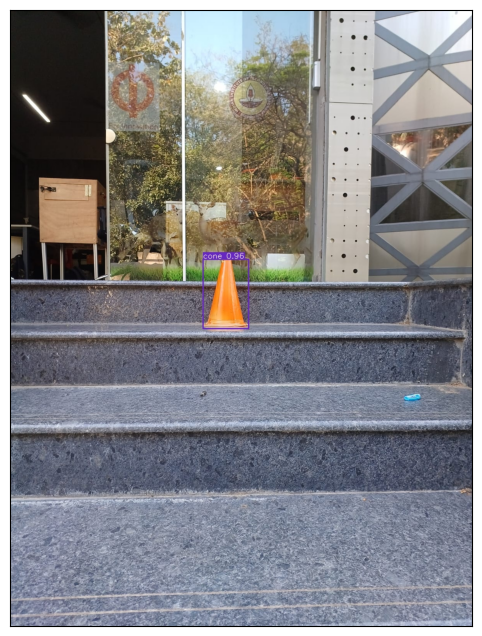

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt

image = plt.imread('runs\detect\exp9\cone_120.jpg')
width, height = image.shape[1], image.shape[0]
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)